In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
RNN_Type = 'GRU'
CNN_fix = 'nonFix' #'nonFix'
SEQ_SIZE = 10 # input frame number [-n,n+1]

In [3]:
# Data allocation (Mouse #)
TRAIN = [1,2,3]
VALID = [4]
TEST = [5]

In [4]:
TRAIN = f'[{TRAIN[0]}{TRAIN[1]}{TRAIN[2]}]'
VALID = VALID[0]
TEST = TEST[0]

In [5]:
print(TRAIN)
print(VALID)
print(TEST)

[123]
4
5


In [6]:
df = pd.read_csv('./data_64_5mice.csv')
df

,Data_ID,Mouse_#
0,20180125_Emx1G6_LR_1,1
1,20180125_Emx1G6_R_1,3
2,20180125_Emx1G6_non_1,2
3,20180126_Emx1G6_LR_1,1
4,20180126_Emx1G6_R_1,3
...,...,...
59,20180411_Emx1G6_non_1,5
60,20180412_Emx1G6_L_1,4
61,20180412_Emx1G6_non_1,5
62,20180413_Emx1G6_L_1,4


In [7]:
def get_filename(mouse_No):
    filename = np.empty(0)
    for i in mouse_No:
        files = df[df['Mouse_#'] == i]['Data_ID'].values
        filename = np.hstack([filename, files])
    return filename

In [8]:
import tifffile
import gc

def load_image(filename):
    raw_image = tifffile.imread(filename)
    X_tmp = (raw_image - raw_image.mean(axis=0)) / raw_image.std() # normalize
    # 3 channel image
    ax = X_tmp.shape
    X = np.zeros([ax[0] - 2, 3, ax[1], ax[2]])
    X[:,0,:,:] = X_tmp[:-2, :, :]
    X[:,1,:,:] = X_tmp[1:-1, :, :]
    X[:,2,:,:] = X_tmp[2:, :, :]
    del X_tmp
    gc.collect();
    return X

In [9]:
from scipy import io

def load_runrest(filename):
    content = io.loadmat(filename)
    Y = content['runrest'][:,1:-1].reshape([-1,1])
    del content
    gc.collect();
    return Y

 # Stage1

In [10]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [11]:
BATCH_SIZE = 8 # 64
VER = 'b0'
from efficientnet_pytorch import EfficientNet
cnn = EfficientNet.from_pretrained('efficientnet-'+VER, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [12]:
FEATURE_SIZE = 1280 # efficient-net b0の時は1280
RNN_UNITS = 128

if RNN_Type == 'RNN':
    rnn = nn.RNN(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)
elif RNN_Type == 'LSTM':
    rnn = nn.LSTM(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)
elif RNN_Type == 'GRU':
    rnn = nn.GRU(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)

In [13]:
# Model
class CNN_RNN(nn.Module):
    def __init__(self,cnn):
        super(CNN_RNN, self).__init__()
        self.cnn = cnn
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.rnn = rnn
        self.linear_out = nn.Linear(RNN_UNITS, 1)

    def forward(self, x):
        x = x.reshape(-1, 3, x.shape[3], x.shape[4]) # (batch, channel, size1, size2)
        x = self.cnn.extract_features(x)
        x = self.avgpool(x)
        x = x.reshape(-1, 2*SEQ_SIZE+1, FEATURE_SIZE) # (batch, seq_len, input_size)
        self.rnn.flatten_parameters()
        o_rnn, _ = self.rnn(x)
        output = self.linear_out(o_rnn[:,-1,:])
        return output

In [14]:
# Model
model = CNN_RNN(cnn).cuda()

In [15]:
# Load model
model.load_state_dict(torch.load(f'./stage2_model/model_EfficientNet{VER}_{RNN_Type}_seq{SEQ_SIZE}_valid{VALID}_test{TEST}_{CNN_fix}.pth'))

<All keys matched successfully>

In [16]:
# For prediction
model.eval()

CNN_RNN(
  (cnn): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_

In [17]:
class ImageDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.targets.shape[0] - 2*SEQ_SIZE)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx:idx+2*SEQ_SIZE+1, :, :, :], dtype=torch.float)
        y = torch.tensor(self.targets[idx+SEQ_SIZE, :], dtype=torch.float)            
        return x, y

In [18]:
from tqdm.auto import tqdm

image_path = './data_of_image_64_5mice/'
behavior_path = './data_of_behavior_64_5mice/'

def inference_1_image(filename):
    X = load_image(image_path + filename + '.tif')
    Y = load_runrest(behavior_path + filename + '_behavior.mat')
    ds_i = ImageDataset(X, Y)
    Y_pred = np.zeros([len(ds_i), 1])
    Y_true = np.zeros([len(ds_i), 1])
    infe = DataLoader(ds_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=10, pin_memory=True)
    tqdm_loader = tqdm(infe)
    for idx, (imgs,labels) in enumerate(tqdm_loader):
        bs = labels.shape[0]
        Y_pred[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = torch.sigmoid(model(imgs.cuda())).cpu().detach().numpy()
        Y_true[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = labels
    del X, Y, ds_i, infe, tqdm_loader
    gc.collect();
    return Y_pred, Y_true

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

def calculate_accuracy(filemanes):
    Y_pred_all = []
    Y_true_all = []
    acc = np.zeros(len(filemanes))
    for i, filename in enumerate(filemanes):
        print(filename)
        Y_pred, Y_true = inference_1_image(filename)
        Y_pred_all.append(Y_pred)
        Y_true_all.append(Y_true)
        output = Y_pred > 0.5
        accuracy = (output == Y_true).mean()
        print('Accuracy: {}'.format(accuracy))
        AUC = roc_auc_score(Y_true, Y_pred)
        print(f'AUC: {AUC}')
        acc[i] = accuracy
    print('Mean Accuracy: {}'.format(acc.mean()))
    return Y_pred_all, Y_true_all

In [20]:
infer_data = list(get_filename([TEST]))
infer_data

['20180321_Emx1G6_non_1',
 '20180323_Emx1G6_non_1',
 '20180326_Emx1G6_non_1',
 '20180327_Emx1G6_non_1',
 '20180328_Emx1G6_non_1',
 '20180403_Emx1G6_non_1',
 '20180405_Emx1G6_non_1',
 '20180406_Emx1G6_non_1',
 '20180409_Emx1G6_non_1',
 '20180411_Emx1G6_non_1',
 '20180412_Emx1G6_non_1',
 '20180413_Emx1G6_non_1']

In [21]:
Y_pred, Y_true = calculate_accuracy(infer_data)

20180321_Emx1G6_non_1



Accuracy: 0.9791411725442207
AUC: 0.9919842872344987
20180323_Emx1G6_non_1



Accuracy: 0.9654577817332295
AUC: 0.7067435503324782
20180326_Emx1G6_non_1



Accuracy: 0.9447658248970965
AUC: 0.901553953998547
20180327_Emx1G6_non_1



Accuracy: 0.9556124151741017
AUC: 0.9732135429023802
20180328_Emx1G6_non_1



Accuracy: 0.9386472355100679
AUC: 0.950010827224843
20180403_Emx1G6_non_1



Accuracy: 0.9479919902102569
AUC: 0.9781784459977536
20180405_Emx1G6_non_1



Accuracy: 0.9265769273556569
AUC: 0.9339987166097905
20180406_Emx1G6_non_1



Accuracy: 0.9410946712648793
AUC: 0.9889429442924974
20180409_Emx1G6_non_1



Accuracy: 0.9705195238624986
AUC: 0.9724176845459374
20180411_Emx1G6_non_1



Accuracy: 0.9086105239737456
AUC: 0.9615701081759346
20180412_Emx1G6_non_1



Accuracy: 0.9593391923462009
AUC: 0.9637801659882336
20180413_Emx1G6_non_1



Accuracy: 0.9397597063077094
AUC: 0.9842576975068826
Mean Accuracy: 0.9481264137649722


In [22]:
# Save test result
from scipy import io
io.savemat(f"./result/test_result_EfficientNet{VER}_{RNN_Type}_seq{SEQ_SIZE}_valid{VALID}_test{TEST}_{CNN_fix}.mat", 
           {"test_label":Y_true, "test_pred":Y_pred})

In [23]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[np.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))

In [24]:
test_pred = np.vstack(Y_pred)
test_true = np.vstack(Y_true)

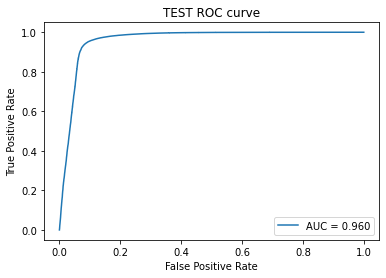

AUC: 0.960
Optimal threshold: 0.885


In [25]:
plot_roc(test_pred, test_true, "TEST")